# Simulating fleets of automated vehicles (AVs) making routing decisions: Medium traffic network, AV behaviors, IPPO/MAPPO algorithm implementation

> In this notebook, on the `Cologne` network, we simulate **100 human agents** for `950 days`. After 100 days **40 of the human agents** mutate into automated vehicles (AVs) and use the [`MAPPO`]((https://arxiv.org/pdf/2103.01955)) (Multi-agent Proximal Policy Optimization) algorithm implemented from the `TorchRL` library to learn the optimal route. The AVs are `malicious` and their goal is to maximize human travel time. Since all AVs share the same reward signal, we model them using an algorithm that can be suitable for collaborative MARL tasks. 

---

> This tutorial is based on [Multi-Agent Reinforcement Learning (PPO) with TorchRL Tutorial](https://pytorch.org/rl/stable/tutorials/multiagent_ppo.html).

#### Imported libraries

In [1]:
import torch
from tqdm import tqdm

from tensordict.nn import TensorDictModule
from torchrl.collectors import SyncDataCollector
from torch.distributions import Categorical
from torchrl.envs.libs.pettingzoo import PettingZooWrapper
from torchrl.envs.transforms import TransformedEnv, RewardSum
from torchrl.envs.utils import check_env_specs
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.modules import MultiAgentMLP, ProbabilisticActor
from torchrl.objectives.value import GAE
from torchrl.objectives import ClipPPOLoss, ValueEstimators

import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))


# Now you can import the module
from routerl import TrafficEnvironment

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


#### Hyperparameters setting

In [2]:
# Devices
device = (
    torch.device(0)
    if torch.cuda.is_available()
    else torch.device("cpu")
)
print("device is: ", device)

# Sampling
frames_per_batch = 40  # Number of team frames collected per training iteration
n_iters = 10  # Number of sampling and training iterations - the episodes the plotter plots
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 1  # Number of optimization steps per training iteration
minibatch_size = 2  # Size of the mini-batches in each optimization step
lr = 3e-4 # Learning rate
max_grad_norm = 3.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss


policy_network_depth=3
policy_network_num_cells = 64

critic_network_depth=3
critic_network_num_cells = 64

# Human learning phase
human_learning_episodes = 200
new_machines_after_mutation = 10

# number of episodes the AV training will take
training_episodes = (frames_per_batch / new_machines_after_mutation) * n_iters

env_params = {
    "agent_parameters" : {
        "new_machines_after_mutation": new_machines_after_mutation,

        "human_parameters" :
        {
            "model" : "gawron",

            "noise_weight_agent" : 0,
            "noise_weight_path" : 0.8,
            "noise_weight_day" : 0.2,

            "beta" : -1,
            "beta_k_i_variability" : 0.1,
            "epsilon_i_variability" : 0.1,
            "epsilon_k_i_variability" : 0.1,
            "epsilon_k_i_t_variability" : 0.1,

            "greedy" : 0.1,
            "gamma_c" : 0.0,
            "gamma_u" : 0.0,
            "remember" : 1,

            "alpha_zero" : 0.8,
            "alphas" : [0.2]  
        },
        "machine_parameters" :
        {
            "behavior" : "cooperative",
        }
    },
    "simulator_parameters" : {
        "network_name" : "two_route_yield",
        "sumo_type" : "sumo",
    },  
    "plotter_parameters" : {
        "phases" : [0, human_learning_episodes, int(training_episodes) + human_learning_episodes],
        "smooth_by" : 50,
        "phase_names" : [
            "Human learning", 
            "Mutation - Machine learning",
            "Testing phase"
        ],
        "records_folder" : "records"
    },
    "path_generation_parameters":
    {
        "number_of_paths" : 4,
        "beta" : -.5,
        "visualize_paths" : True
    }
}

device is:  cpu


#### Environment initialization

> In this example, the environment initially contains only human agents.

> If the paths are already created then create_paths=False, we don't have to create again.

In [3]:
env = TrafficEnvironment(seed=42, create_agents=False, create_paths=True, **env_params)

[CONFIRMED] Environment variable exists: SUMO_HOME
[SUCCESS] Added module directory: C:\Program Files (x86)\Eclipse\Sumo\tools


In [4]:
print("Number of total agents is: ", len(env.all_agents), "\n")
print("Number of human agents is: ", len(env.human_agents), "\n")
print("Number of machine agents (autonomous vehicles) is: ", len(env.machine_agents), "\n")

Number of total agents is:  22 

Number of human agents is:  22 

Number of machine agents (autonomous vehicles) is:  0 



> Reset the environment and the connection with SUMO

In [5]:
env.start()
env.reset()

({}, {})

#### Human learning

In [6]:
for episode in range(human_learning_episodes):
    env.step()

this is my noise: 
[0.08346696420666122, -0.019262547486851214]
I act based on those utilities:{'utilities': [-0.27238984639410974, -0.21428858205480947], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([0.24022078, 0.22174226])}
I act
this is my noise: 
[-0.03551099722380284, 0.03475261787591691]
I act based on those utilities:{'utilities': [-0.22658598999908622, -0.2660549628359618], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([0.24022078, 0.22174226])}
I act
this is my noise: 
[-0.1569096388682463, -0.1319624797543704]
I act based on those utilities:{'utilities': [-0.19452487441459804, -0.18235375536951448], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([0.24022078, 0.22174226])}
I act
this is my noise: 
[-0.065845506757964, -0.11313189910571479]
I act based on those utilities:{'utilities': [-0.21235956045037058, -0.17579880351526053], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([0.24022078, 0.2217

#### Mutation

> **Mutation**: a portion of human agents are converted into machine agents (autonomous vehicles). 

In [7]:
env.mutation()

In [8]:
print("Number of total agents is: ", len(env.all_agents), "\n")
print("Number of human agents is: ", len(env.human_agents), "\n")
print("Number of machine agents (autonomous vehicles) is: ", len(env.machine_agents), "\n")

Number of total agents is:  22 

Number of human agents is:  12 

Number of machine agents (autonomous vehicles) is:  10 



> `TorchRL` enables us to make different groups with different agents. Here, all the AV agents are included in one group.

In [9]:
group = {'agents': [str(machine.id) for machine in env.machine_agents]}

#### PettingZoo environment wrapper

In [10]:
env = PettingZooWrapper(
    env=env,
    use_mask=True, # Whether to use the mask in the outputs. It is important for AEC environments to mask out non-acting agents.
    categorical_actions=True,
    done_on_any = False, # Whether the environment’s done keys are set by aggregating the agent keys using any() (when True) or all() (when False).
    group_map=group,
    device=device
)

#### Transforms

In [11]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

The <code style="color:white">check_env_specs()</code> function runs a small rollout and compared it output against the environment specs. It will raise an error if the specs aren't properly defined.

In [12]:
check_env_specs(env)


2025-03-19 14:49:14,773 [torchrl][INFO] check_env_specs succeeded!


this is my noise: 
[0.10600231703073716, -0.042599846226743274]
I act based on those utilities:{'utilities': [-0.2778536486150515, 0.502790513244481], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.06559832078775371, 0.039532755566729194]
I act based on those utilities:{'utilities': [0.6984076486397223, -0.26733345090709193], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.16155193792445943, -0.14804515687915634]
I act based on those utilities:{'utilities': [-0.19350228071337416, 0.9860301249386889], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.07297958563999926, -0.1341554169537091]
I act based on those utilities:{'utilities': [-0.21080437606625374, 0.9565230373212444], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -1.0

In [13]:
reset_td = env.reset()

#### Policy/Actor network

In [14]:
share_parameters_policy = False 

policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs = env.observation_spec["agents", "observation"].shape[-1],
        n_agent_outputs = env.action_spec.space.n,
        n_agents = env.n_agents,
        centralised=False,
        share_params=share_parameters_policy,
        device=device,
        depth=policy_network_depth,
        num_cells=policy_network_num_cells,
        activation_class=torch.nn.Tanh,
    ),
)

In [15]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "logits")],
) 

In [16]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=[("agents", "logits")],
    out_keys=[env.action_key],
    distribution_class=Categorical,
    return_log_prob=True,
    log_prob_key=("agents", "sample_log_prob"),
)

#### Critic network

> The critic reads the observations and returns the corresponding value estimates.

In [17]:
share_parameters_critic = True
mappo = True  # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
    n_agent_outputs=1, 
    n_agents=env.n_agents,
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=critic_network_depth,
    num_cells=critic_network_num_cells,
    activation_class=torch.nn.ReLU,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "state_value")],
)

#### Collector

In [18]:
collector = SyncDataCollector(
    env,
    policy,
    device=device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
) 

#### Replay buffer

In [19]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,
)

#### PPO loss function

In [20]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,
)
loss_module.set_keys( 
    reward=env.reward_key,  
    action=env.action_key, 
    sample_log_prob=("agents", "sample_log_prob"),
    value=("agents", "state_value"),
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)

loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
) 

GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

#### Training loop

In [21]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

episode_reward_mean_list = []
loss_values = []
loss_entropy = []
loss_objective = []
loss_critic = []

for tensordict_data in collector: ##loops over frame_per_batch

    ## Generate the rollouts
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),  # Adjust index to start from 0
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),  # Adjust index to start from 0
    )

    # Compute GAE for all agents
    with torch.no_grad():
            GAE(
                tensordict_data,
                params=loss_module.critic_network_params,
                target_params=loss_module.target_critic_network_params,
            )

    data_view = tensordict_data.reshape(-1)  
    replay_buffer.extend(data_view)

    ## Update the policies of the learning agents
    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            ) 

            optim.step()
            optim.zero_grad()

            loss_values.append(loss_value.item())

            loss_entropy.append(loss_vals["loss_entropy"].item())

            loss_objective.append(loss_vals["loss_objective"].item())

            loss_critic.append(loss_vals["loss_critic"].item())


   
    collector.update_policy_weights_()
   
    # Logging
    done = tensordict_data.get(("next", "agents", "done"))  # Get done status for the group

    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)


    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = 0:   0%|          | 0/10 [00:00<?, ?it/s]

this is my noise: 
[0.14522009688398327, 0.0009917786393636406]
I act based on those utilities:{'utilities': [-0.2873621836859401, 0.49286086979606863], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.030536125041261478, 0.07092944289958864]
I act based on those utilities:{'utilities': [0.6904985502695027, -0.27573075927442536], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.17185976397305347, -0.15905889261344602]
I act based on those utilities:{'utilities': [-0.19123169929176229, 0.9884556141498533], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.07737896702414045, -0.11566824989253238]
I act based on those utilities:{'utilities': [-0.20984533855888615, 0.9526853418804673], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -

episode_reward_mean = -1.3058332204818726:  10%|█         | 1/10 [00:02<00:21,  2.40s/it]

this is my noise: 
[0.13032737957214227, -0.020676701152628544]
I act based on those utilities:{'utilities': [-0.283751374369595, 0.4977966866889806], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.004039575122608635, 0.05462002884698864]
I act based on those utilities:{'utilities': [0.6845216336698335, -0.271368669171153], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.15605030384467233, -0.16837311827215093]
I act based on those utilities:{'utilities': [-0.194714166524328, 0.9905068304120345], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.11936053998279882, -0.10440350475547236]
I act based on those utilities:{'utilities': [-0.20069361935791463, 0.9503469272974782], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -1.0333

episode_reward_mean = -1.2320833206176758:  20%|██        | 2/10 [00:05<00:21,  2.73s/it]

this is my noise: 
[0.1249708289210554, -0.021741224902896584]
I act based on those utilities:{'utilities': [-0.2824526534854593, 0.49803917228833583], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.07237196300240288, 0.03542339270201531]
I act based on those utilities:{'utilities': [0.6999356020795946, -0.2662343672106997], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.1759945234995343, -0.11555024959274052]
I act based on those utilities:{'utilities': [-0.1903209050933153, 0.9788739656715287], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.04944027579372461, -0.08574907784001885]
I act based on those utilities:{'utilities': [-0.21593579775238045, 0.9464745108863079], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -1.033

episode_reward_mean = -1.3070833683013916:  30%|███       | 3/10 [00:07<00:18,  2.67s/it]

this is my noise: 
[0.11363691826502573, 0.0015767869856267089]
I act based on those utilities:{'utilities': [-0.2797046935711946, 0.4927276119899974], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.04452727470203578, 0.06328485925425412]
I act based on those utilities:{'utilities': [0.6936545813344025, -0.2736861510159431], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.12093721195809037, -0.1608023423364437]
I act based on those utilities:{'utilities': [-0.20244878813291614, 0.9888395636648369], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.0856809691221646, -0.11498485328565004]
I act based on those utilities:{'utilities': [-0.20803555424990341, 0.9525434776330249], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -1.033

episode_reward_mean = -1.320833444595337:  40%|████      | 4/10 [00:10<00:16,  2.78s/it] 

this is my noise: 
[0.1257353485907582, -0.011208223620664558]
I act based on those utilities:{'utilities': [-0.2826380148730482, 0.49563988234455697], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.027355976250650713, 0.03195308252434663]
I act based on those utilities:{'utilities': [0.6897811933247543, -0.26530620353587525], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.11002095245538264, -0.10227454963565083]
I act based on those utilities:{'utilities': [-0.20485339371157965, 0.9759503375953322], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.03538673231409123, -0.12557178033095245]
I act based on those utilities:{'utilities': [-0.21899938195468996, 0.9547411859957583], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -1

episode_reward_mean = -1.3929166793823242:  50%|█████     | 5/10 [00:13<00:13,  2.67s/it]

this is my noise: 
[0.11892334305997151, -0.019713580547213772]
I act based on those utilities:{'utilities': [-0.2809864121118783, 0.4975772994961663], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.03385001774544095, 0.05604281027003344]
I act based on those utilities:{'utilities': [0.6912460762822833, -0.271749204041662], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.15981246089577314, -0.1267496359873378]
I act based on those utilities:{'utilities': [-0.19388544824123463, 0.9813403396183075], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.05964982873943916, -0.14713115517981531]
I act based on those utilities:{'utilities': [-0.2137101793407349, 0.9592166318166185], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -1.0333

episode_reward_mean = -1.278333306312561:  60%|██████    | 6/10 [00:16<00:11,  2.82s/it] 

this is my noise: 
[0.1269330403083948, -0.039035220705355596]
I act based on those utilities:{'utilities': [-0.28292840085980914, 0.5019785347838659], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.026607420266083766, 0.05791660699652361]
I act based on those utilities:{'utilities': [0.6896123390133939, -0.2722503667523397], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.1328111454387033, -0.126187029686899]
I act based on those utilities:{'utilities': [-0.1998332285924821, 0.9812164401944636], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.09427494796697809, -0.14302960115362895]
I act based on those utilities:{'utilities': [-0.20616212084415006, 0.9583652025449345], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -1.0333

episode_reward_mean = -1.3574998378753662:  70%|███████   | 7/10 [00:19<00:08,  2.74s/it]

this is my noise: 
[0.1408827194192282, -0.02118132624862179]
I act based on those utilities:{'utilities': [-0.2863105661315136, 0.49791163416555945], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.07832688137243964, 0.02227864087736211]
I act based on those utilities:{'utilities': [0.7012788732060175, -0.2627186926647371], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.14570565570464591, -0.13429714324879766]
I act based on those utilities:{'utilities': [-0.1969928590215747, 0.9830024820444111], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.09087757179506972, -0.10779589628156014]
I act based on those utilities:{'utilities': [-0.2069027275092694, 0.9510511436573951], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -1.0333

episode_reward_mean = -1.4204165935516357:  80%|████████  | 8/10 [00:21<00:05,  2.76s/it]

this is my noise: 
[0.12206811297584842, -0.018097294825391026]
I act based on those utilities:{'utilities': [-0.2817488763601577, 0.4972091292116735], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.04805132648610346, 0.05862865094090735]
I act based on those utilities:{'utilities': [0.6944495136433617, -0.27244080890022276], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.16430429577558756, -0.10480503662387844]
I act based on those utilities:{'utilities': [-0.19289599840195976, 0.9765076116245093], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.05980102420382565, -0.10287642858241405]
I act based on those utilities:{'utilities': [-0.21367721967922132, 0.9500299261448585], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -1.

episode_reward_mean = -1.380833387374878:  90%|█████████ | 9/10 [00:24<00:02,  2.79s/it] 

this is my noise: 
[0.11440627489697532, -0.051234249352224134]
I act based on those utilities:{'utilities': [-0.27989122770301667, 0.5047573255550847], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.0015631850402542044, 0.03241780166285056]
I act based on those utilities:{'utilities': [0.6839630259629463, -0.26543049658210804], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.14794192467458636, -0.14501439175048705]
I act based on those utilities:{'utilities': [-0.19650025944209631, 0.9853626776439192], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.09187717445716091, -0.10429349416173751]
I act based on those utilities:{'utilities': [-0.20668482040786065, 0.9503240905289989], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, 

episode_reward_mean = -1.3920834064483643: 100%|██████████| 10/10 [00:27<00:00,  2.87s/it]

> Testing phase

In [22]:
policy.eval() # set the policy into evaluation mode

num_episodes = 100

for episode in range(num_episodes):
    env.rollout(len(env.machine_agents), policy=policy)

this is my noise: 
[0.10744721161810436, -0.022093889665963196]
I act based on those utilities:{'utilities': [-0.2782039700995702, 0.4981195050441078], 'self.beta_k_i': array([-1.04967142, -0.98617357]), 'costs': array([ 0.24022078, -0.5       ])}
I act
this is my noise: 
[-0.028719772431512115, 0.04680500786648137]
I act based on those utilities:{'utilities': [0.6900888294531174, -0.26927847601240473], 'self.beta_k_i': array([-0.9765863 , -1.15792128]), 'costs': array([-0.7       ,  0.22174226])}
I act
this is my noise: 
[-0.13814894910315215, -0.13657649867999697]
I act based on those utilities:{'utilities': [-0.19865743092422763, 0.9835044508713523], 'self.beta_k_i': array([-0.95365823, -0.95342702]), 'costs': array([ 0.24022078, -1.        ])}
I act
this is my noise: 
[-0.03161173675998525, -0.08685195472092237]
I act based on those utilities:{'utilities': [-0.21982230727314134, 0.9467034537829441], 'self.beta_k_i': array([-0.94377125, -0.89871689]), 'costs': array([ 0.24022078, -1

>  Check `\plots` directory to find the plots created from this experiment.

In [23]:
env.plotter_params['phases'] =[0, human_learning_episodes, int(training_episodes) + human_learning_episodes],


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

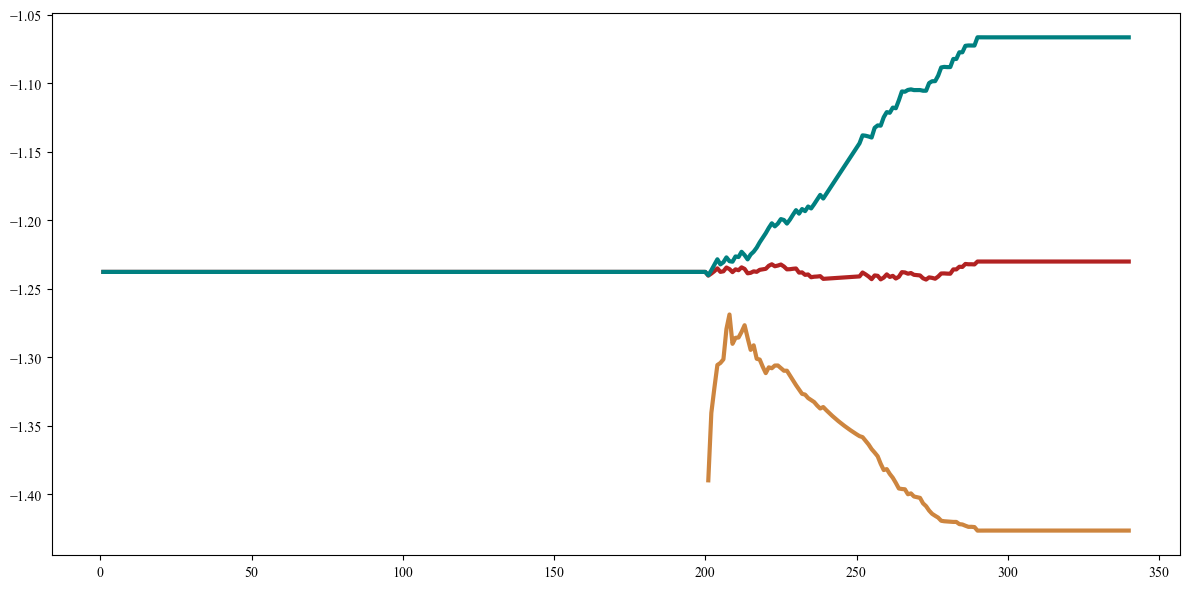

In [24]:
env.plot_results()

> The plots reveal that the introduction of AVs into urban traffic influences human agents' decision-making. This insight highlights the need for research aimed at mitigating potential negative effects of AV introduction, such as increased human travel times, congestion, and subsequent rises in $CO_2$ emissions.

| |  |
|---------|---------|
| **Action shifts of human and AV agents** ![](plots_saved/mappo_actions_shifts.png) | **Action shifts of all vehicles in the network** ![](plots_saved/mappo_actions.png) |
| ![](plots_saved/mappo_rewards.png) | ![](plots_saved/mappo_travel_times.png) |


<p align="center">
  <img src="plots_saved/mappo_tt_dist.png" width="700" />
</p>


> Interrupt the connection with `SUMO`.

In [ ]:
env.stop_simulation()